In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))

2.10.0
1


In [2]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1, 28, 28, 1)
#x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [7]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn1"),  
        keras.layers.Conv2D(32, (3, 3),name="conv2", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn2"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn3"),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn4"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn5"),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn6"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),
        keras.layers.Dropout(0.2),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu', kernel_initializer='he_uniform'),
        keras.layers.BatchNormalization(name="bn7"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, name="dense3", activation='softmax')
    ],
    name="modelo-0.0",
)

for layer in model.trainable_variables:
    #print(layer.name)
    if 'bias' in layer.name:
        new_bias = tf.cast(tf.where(tf.abs(layer) >= 0, 0.1, 0.1), tf.float32)
        layer.assign(new_bias)

model.summary()

Model: "modelo-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 bn1 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 bn2 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 mp1 (MaxPooling2D)          (64, 16, 16, 32)          0         
                                                                 
 dropout_4 (Dropout)         (64, 16, 16, 32)          0         
                                                                 
 conv3 (Conv2D)              (64, 16, 16, 64)          1

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class PruningFBQuantizationTrainer:
    def __init__(self, model, train_ds, test_ds, loss_fn,
                 train_accuracy, test_accuracy,
                 epochs=40, n_bits=4, alpha=0.5, learning_rate=0.05, momentum =0.9):

        self.model = model
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.loss_fn = loss_fn
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy

        # hyperparameters
        self.epochs = epochs
        self.n_bits = n_bits
        self.learning_rate = learning_rate
        self.momentum = 0.9
        self.alpha = alpha
        self.v = [tf.zeros_like(w) for w in self.model.trainable_variables]

        # logs
        self.model_sparsity = []
        self.model_train_loss = []
        self.model_train_acc = []
        self.model_test_loss = []
        self.model_test_acc = []

    def quantize_weights_with_bk(self, bk):
        """
        Quantiza os pesos atuais (já podados). Usa bk por camada para ajustar step.
        Retorna lista de tensors quantizados (não altera original aqui).
        """
        q_weights = []
        denom = (2 ** (self.n_bits - 1) - 1) if self.n_bits > 0 else 1.0

        for i, w in enumerate(self.model.trainable_variables):
            if 'bn' in w.name or self.n_bits <= 0:
                q_weights.append(tf.identity(w))
                continue

            # calculo do step considerando bk (não negativo)
            scale_base = tf.reduce_max(tf.abs(w))
            # tentar reduzir influência de pequenos valores com bk[i]
            adjusted = tf.maximum(scale_base - (bk[i] if i < len(bk) else 0.0), 0.0)
            step = tf.maximum(adjusted / denom, 1e-9)

            q = tf.round(w / step) * step
            q_weights.append(q)

        return q_weights
    
    
    def prune_weights(self, alpha):
        """Aplica poda baseada em desvio padrão."""
        bk = []
        n_zeros, size = 0, 0
        sparsity = 0

        for layer_weights in self.model.trainable_variables:
            if 'bn' in layer_weights.name:
                bk.append(-1)
                continue
            #Lista de Pesos da camada
            f_weights = tf.reshape(layer_weights, [-1])
            #Calculo de B_k
            lim = alpha * tf.math.reduce_std(f_weights)
            bk.append(lim)

            #Máscara de poda
            mask = tf.cast(tf.where(tf.abs(layer_weights) > lim, 1, 0), tf.float32)
            layer_weights.assign(tf.math.multiply(layer_weights, mask))

            #Calculo de esparsidade
            flat_array = np.array(tf.reshape(mask, [-1]))
            n_zeros += np.count_nonzero(flat_array == 0)
            size += flat_array.shape[0]
            sparsity = n_zeros * 100 / size

        return bk, sparsity

    def train(self):
        np.set_printoptions(threshold=np.inf)

        for epoch in range(self.epochs):
            acc_epoch_mean, loss_epoch_mean = [], []
            acct_epoch_mean, losst_epoch_mean = [], []
            
            sparsity = 0
            # Treino
            for step, (x_batch_train, y_batch_train) in enumerate(self.train_ds):
                
                
                # poda
                if self.alpha > 0:
                    bk, sparsity = self.prune_weights(self.alpha)
                
                # pesos originais
                original_weights = [tf.identity(w) for w in self.model.trainable_variables]
                
                # Quantização
                if self.n_bits > 0:
                    q_weights = self.quantize_weights_with_bk(bk)
                    for w, q in zip(self.model.trainable_variables, q_weights):
                        w.assign(q)
                
                with tf.GradientTape() as tape:
                    pred = self.model(x_batch_train, training=True)
                    loss = self.loss_fn(y_batch_train, pred)

                grads = tape.gradient(loss, self.model.trainable_weights)
                
                for w, w_orig in zip(self.model.trainable_variables, original_weights):
                    w.assign(w_orig)

                # atualização manual dos pesos
                for i, w in enumerate(self.model.trainable_variables):
                    g = grads[i]
                    g = tf.clip_by_value(g, -1.0, 1.0)
                    delta = - self.learning_rate * g
                    # momentum update
                    self.v[i] = self.momentum * self.v[i] + delta
                    w.assign_add(self.v[i])
                
                predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
                yy = tf.argmax(y_batch_train, axis=1, output_type=tf.int32)
                acc = self.train_accuracy(tf.reshape(y_batch_train, [-1]), predictions)
                #print(float(acc), float(loss))
                acc_epoch_mean.append(acc)
                loss_epoch_mean.append(loss)

                self.train_accuracy.update_state(yy,predictions)
                
                #print(f"{epoch}/{step} acc = {acc}, loss: {loss}")
                #print(predictions)
                #print("---")
                #print(tf.reshape(y_batch_train, [-1]))
            #self.train_accuracy.reset_states()

            if self.alpha > 0:
                bk, sparsity = self.prune_weights(self.alpha)
            if self.n_bits > 0:
                q_weights = self.quantize_weights_with_bk(bk)
                for w, q in zip(self.model.trainable_variables, q_weights):
                    w.assign(q)

            # Teste
            for step, (x_batch_test, y_batch_test) in enumerate(self.test_ds):
                test_pred = self.model(x_batch_test, training=False)
                test_loss = self.loss_fn(y_batch_test, test_pred)
                test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
                
                test_acc = self.test_accuracy(tf.reshape(y_batch_test, [-1]), test_prediction)

                acct_epoch_mean.append(test_acc)
                losst_epoch_mean.append(test_loss)

            #self.test_accuracy.reset_states()

            # salvar métricas
            self.model_test_acc.append(np.mean(acct_epoch_mean) * 100)
            self.model_test_loss.append(np.mean(losst_epoch_mean) * 100)
            self.model_sparsity.append(sparsity)
            self.model_train_acc.append(np.mean(acc_epoch_mean))
            self.model_train_loss.append(np.mean(loss_epoch_mean))

            print("Epoch {}/{} \t Loss = {:.3f} \t Sparsity = {:.3f}% \t Train Acc = {:.3f}% \t Test Acc = {:.3f}%".format(
                epoch + 1, self.epochs, float(loss), float(sparsity), float(acc * 100), float(test_acc * 100)
            ))


In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
train_accuracy = tf.keras.metrics.Accuracy()
test_accuracy = tf.keras.metrics.Accuracy()

In [10]:
trainer = PruningFBQuantizationTrainer(model, train_ds, test_ds, loss_fn, train_accuracy, test_accuracy, epochs=5)
trainer.train()

Epoch 1/5 	 Loss = 0.816 	 Sparsity = 55.133% 	 Train Acc = 29.076% 	 Test Acc = 52.490%
Epoch 2/5 	 Loss = 0.744 	 Sparsity = 60.399% 	 Train Acc = 33.172% 	 Test Acc = 59.025%
Epoch 3/5 	 Loss = 0.802 	 Sparsity = 63.481% 	 Train Acc = 35.533% 	 Test Acc = 63.803%
Epoch 4/5 	 Loss = 1.923 	 Sparsity = 65.483% 	 Train Acc = 37.080% 	 Test Acc = 64.503%
Epoch 5/5 	 Loss = 0.746 	 Sparsity = 66.868% 	 Train Acc = 38.234% 	 Test Acc = 66.524%


conv1/kernel:0
conv2/kernel:0
conv3/kernel:0


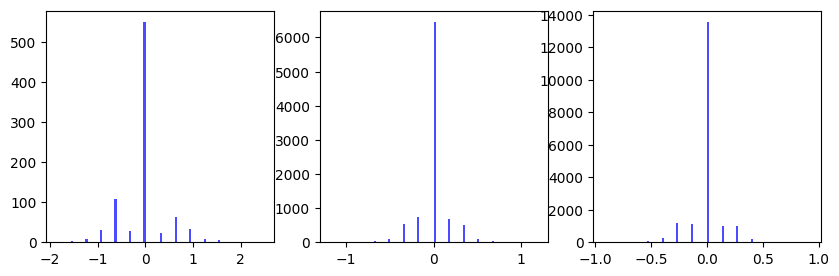

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
i = 0
for l in trainer.model.trainable_weights:
    if "kernel" in l.name:
        print(l.name)
        f_w = tf.reshape(l, [-1])
        axes[i].hist(f_w, bins=100, color="blue", alpha=0.7)
        i+=1
        if i == 3:
            break
plt.show()